# Определение перспективного тарифа для телеком-компании

*Заказчик: Коммерческий департамент федерального оператора сотовой связи "Мегалайн".*



**Цель проекта:**

**Из двух тарифов "Смарт" и "Ультра" выбрать более доходный для дальнейшей корректировки рекламного бюджета.**

**Задачи проекта:**
- Проанализировать поведение клиентов: дать портрет клиента в каждом тарифе.
- На основе небольшой выборки проверить гипотезы: 
1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
- Определить наиболее доходный тариф.

**Описание тарифов**

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

*Примечание*
- *«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.*
- *Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.*
- *Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону (если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта*
- *Примем, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.*

**Для анализа были предоставлены:**
- информация о 500 пользователях / таблица users (user_id — уникальный идентификатор пользователя, first_name — имя пользователя, last_name — фамилия пользователя, age — возраст пользователя (годы), reg_date — дата подключения тарифа (день, месяц, год), churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных), city — город проживания пользователя, tariff — название тарифного плана).
- информация о совершенных звонках / таблица calls (id — уникальный номер звонка, call_date — дата звонка, duration — длительность звонка в минутах, user_id — идентификатор пользователя, сделавшего звонок).
- информация об отправленных смс-сообщениях / таблица messages (id — уникальный номер сообщения, message_date — дата сообщения, user_id — идентификатор пользователя, отправившего сообщение).
- информация о проведенных интернет-сессиях / Таблица internet (id — уникальный номер сессии, mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах), session_date — дата интернет-сессии, user_id — идентификатор пользователя).

## Обработка данных и вненение дополнительных 

Импортируем нужные библиотеки, просмотрим и опишем подробнее полученные данные, есть ли в них проблемы, обработаем пропуски, внесем необходимые исправления, скорректируем при необходимости типы данных.

In [299]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from scipy import stats as st


In [300]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
users = pd.read_csv('/datasets/users.csv')

In [298]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Просмотр и описание

In [301]:
def look (data):
    if str(data) == str(calls):
        print('--------------------------------------------------------')
        print('Посмотрим данные о звонках')
        print()
    elif str(data) == str(internet):
        print('--------------------------------------------------------')
        print('Посмотрим данные о Интернет-трафике')
        print()
    elif str(data) == str(messages):
        print('--------------------------------------------------------')
        print('Посмотрим данные о смс-сообщениях')
        print()
    else:
        print('--------------------------------------------------------')
        print('Посмотрим данные об абонентах')
        print()
    print(data.info())
    display(data.describe())
    display(data.head())

In [302]:
data_list = [users, calls, internet, messages]
for data in data_list:
    look(data)

--------------------------------------------------------
Посмотрим данные об абонентах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


--------------------------------------------------------
Посмотрим данные о звонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


--------------------------------------------------------
Посмотрим данные о Интернет-трафике

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


--------------------------------------------------------
Посмотрим данные о смс-сообщениях

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Абоненты:
- в таблице дана информация о 500 абонентах, 38 из которых уже завершили пользование тарифом ( churn_date - информация с датой завершения договоря на один из анализируемых тарифов.)
- даты в типе object, нужно привести к нужному формату 
- минимальный возраст лица, заключившего договор 18 лет (здесь все в порядке), в название столбца добавим единицу измерения возраста - годы/years

- в колонке с данными о городе нужно будет посмотреть неявные дубликаты.

Звонки:
- данные о 202607 звонках, пропусков нет
- вновь формат даты object, нужно привести к нужному формату 
- id звонка в типе object, нужно привести к нужному формату 
- длительность формат float64, можно привести в формат int, округлив в большую сторону (мы считаем доходность, оператор при выставлении счетов время округляет, поэтому точное время звонка до секунды  в данном анализе не нужно).
- длительность звонка минимальная 0 минут, это не ошибка, так как нулями обозначены пропущенные звонки(так указано в пояснительной записке к проекту)
- в названии столбца duration не указана единица изменения, добавим ее

Интернет:
- данные о 149396 интернет-сессиях, пропусков нет
- столбец 'Unnamed: 0' - в нем нет пропусков, судя по данным describe он дублирует индексы. Оставим его как есть.
- вновь формат даты object, тот же формат у id интернет-сессии. Нужно привести к нужным форматам.
- минимальное значение длительности интернет-сессии 0 мб, вероятно означающее, что интернет абонент не использовал.

СМС-сообщения:
- данные 123036 сообщениях, пропусков нет
- дата вновь в формате object, нужно привести к нужному формату 
- id смс-сообщения в типе object, нужно привести к нужному формату


### Обработка данных

#### Дубликаты

Поищем явные дубликаты в каждой из таблиц (кроме таблицы с описанием тарифа).

In [303]:
for data in data_list:
    print(data.duplicated().sum())

0
0
0
0


*Явных дубликатов нет.*

#### Обработка таблиц и добавление столбцов

In [304]:
#для приведения к формату datetime
def date_type(date):
    date = pd.to_datetime(date, format='%Y-%m-%d')
    return date

**Тарифы/tariffs**

Обработаем название столбцов.

In [305]:
tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

In [306]:
tariffs = tariffs.rename(columns={'mb_per_month_included':'mb_included', 'tariff_name':'tariff'})
tariffs

,messages_included,mb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Абоненты / users**

- для дальнейшей работы с датами переведем информацию 'churn_date', 'reg_date' из типа object  к типу datetime64
- в название столбца 'age' добавим единицу измерения возраста - годы/years
- поищем неявные дубликаты в столбце city

In [307]:
# работаем с датами
users['reg_date'] = users['reg_date'].apply(date_type)
users['churn_date'] = users['churn_date'].apply(date_type)

In [308]:
# переименовываем столбец
users = users.rename(columns={'age':'age_years'})
users.columns

Index(['user_id', 'age_years', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

In [309]:
# считаем количество значений в столбце city
len(users['city'].unique())

76

In [310]:
# приводим все названия городов к нижнему регистру и смотрим итог
users['city'] = users['city'].str.lower()
users['city'].unique(), len(users['city'].unique())

(array(['краснодар', 'москва', 'стерлитамак', 'новокузнецк',
        'набережные челны', 'ульяновск', 'челябинск', 'пермь', 'тюмень',
        'самара', 'санкт-петербург', 'иваново', 'чебоксары', 'омск', 'уфа',
        'томск', 'чита', 'мурманск', 'петрозаводск', 'тверь',
        'екатеринбург', 'махачкала', 'вологда', 'череповец', 'ярославль',
        'сочи', 'хабаровск', 'ставрополь', 'рязань', 'улан-удэ', 'тула',
        'саратов', 'ростов-на-дону', 'казань', 'иркутск', 'курск',
        'калуга', 'якутск', 'астрахань', 'химки', 'владикавказ',
        'волгоград', 'саранск', 'ижевск', 'новосибирск', 'брянск',
        'тольятти', 'нижний тагил', 'орёл', 'белгород', 'воронеж',
        'волжский', 'курган', 'барнаул', 'красноярск', 'архангельск',
        'липецк', 'кемерово', 'киров', 'сургут', 'пенза', 'магнитогорск',
        'нижний новгород', 'кострома', 'владивосток', 'тамбов', 'балашиха',
        'севастополь', 'калининград', 'оренбург', 'смоленск',
        'нижневартовск', 'владими

In [311]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age_years   500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


*Неявных дублей нет. Все изменения внесены. В данном анализе нам не потребуется столбец churn_date, пропуски в нем оставим не заполняя.*

**Звонки / calls**

- для дальнейшей работы с датами переведем информацию 'call_date' из типа object  к типу datetime64, отдельно выделим в столбец месяцы
- приведем данные в столбце id к формату 'int'
- к названию столбца 'id' добаыим пояснение 'calls'
- для дальнейших рассчетов каждый звонок округлим в большую сторону
- проанализируем нулевые значения и примем по ним решение

In [312]:
# работаем с датой
calls['call_date'] = calls['call_date'].apply(date_type)
calls['month'] = calls['call_date'].astype('datetime64[M]')
calls[['call_date', 'month']].head()

,call_date,month
0,2018-07-25,2018-07-01
1,2018-08-17,2018-08-01
2,2018-06-11,2018-06-01
3,2018-09-21,2018-09-01
4,2018-12-15,2018-12-01


In [313]:
#переименовываем столбцы
calls = calls.rename(columns={'duration':'duration_minutes', 'id':'id_calls'})

Посмотрим популярные варианты длительности звонка.

In [314]:
# на продолжительность звонка
calls['duration_minutes'].value_counts().head(10)

0.00    39613
5.50      142
4.49      142
6.15      141
6.38      141
4.92      139
8.41      138
5.45      138
5.05      138
5.25      137
Name: duration_minutes, dtype: int64

Самый популярный вариант - 0, остальные показывают варианты длительности от 3 до 11 минут.

Из пояснительной записки к проекту мы знаем, что звонки с длительностью 0 - это пропущенные звонки. Но как их обрабатывает оператор "Мегалайн" не уточнено, есть лишь пояснение, что 0 (пропущенный звонок - не ошибка, удалять его не нужно).

Посмотрим долю нулевых звонков

In [315]:
#посчитаем долю пропущенных звонков
39613/len(calls)

0.19551644316336553

Достаточно много, 19%. Посмотрим как они распределены по тарифам. Для этого объединим данные о звонках и абонентах, а далее сделаем срез данных.

In [316]:
test = calls.merge(users, on='user_id', how='outer')
len(test.query('tariff == "smart" and duration_minutes==0')) / len(test.query('tariff == "smart"'))

0.19697353376765886

In [317]:
len(test.query('tariff == "ultra" and duration_minutes==0')) / len(test.query('tariff == "ultra"'))

0.1928684057650281

Удивительно, но пропущенные звонки распределены по нашим выборкам равномерно. И в Смарт и в Ультра таких звонков 19%

Далее посмотрим минимальное значение длительности звонка (кроме 0).

In [318]:
calls[calls['duration_minutes'] > 0]['duration_minutes'].min()

0.01

Минимум - одна сотая минуты, если бы у оператора в настройках где-то стояло округление в минимальную сторону (np.floor()) здесь мы бы тоже получили 0.

На основании соразмерного распределения нулевых звонков в группах абонентов по тарифам (по 19% от общего количества информации о длительности звонков в каждом тарифе), а также достаточной точности измерений (сотые минуты) - примем решение оставить пропущенные звонки с прежним значением 0, не меняя его.

In [319]:
#округляем каждый звонок в большую сторону
calls['duration_minutes'] = calls['duration_minutes'].apply(np.ceil)

In [320]:
#проверяем проведенные изменения
calls.info(), calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id_calls          202607 non-null  object        
 1   call_date         202607 non-null  datetime64[ns]
 2   duration_minutes  202607 non-null  float64       
 3   user_id           202607 non-null  int64         
 4   month             202607 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 7.7+ MB


(None,
   id_calls  call_date  duration_minutes  user_id      month
 0   1000_0 2018-07-25               0.0     1000 2018-07-01
 1   1000_1 2018-08-17               0.0     1000 2018-08-01
 2   1000_2 2018-06-11               3.0     1000 2018-06-01
 3   1000_3 2018-09-21              14.0     1000 2018-09-01
 4   1000_4 2018-12-15               6.0     1000 2018-12-01)

*Видим все внесенные изменения*

**Интернет**
- приведем данные в столбце id к формату 'int', к названию столбца 'id' добавим пояснение 'session'
- формат даты object переводим в нужный тип datetime64 и добавляем столбец с месяцем 

In [321]:
#переименовываем, приводим к 'int'
internet = internet.rename(columns={'id':'id_session'})
internet['id_session'] = internet['id_session'].astype('int')

In [322]:
#работаем с датой
internet['session_date'] = internet['session_date'].apply(date_type)
internet['month'] = internet['session_date'].astype('datetime64[M]')

In [323]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id_session    149396 non-null  int64         
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   month         149396 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 6.8 MB


*Есть все новые названия и нужные типы данных.*

**СМС-сообщения**
- приведем данные в столбце id к формату 'int' и переименуем в 'id_messages'
- формат даты object переводим в нужный тип datetime64, добавляем месяц в отдельный столбец

In [324]:
#переименовываем и приводим в тип 'int'
messages = messages.rename(columns={'id':'id_messages'})
messages['id_messages'] = messages['id_messages'].astype('int')

In [325]:
#работаем с датой
messages['message_date'] = messages['message_date'].apply(date_type)
messages['month'] = messages['message_date'].astype('datetime64[M]')
#pd.DatetimeIndex(messages['message_date']).month

In [326]:
#проверяем
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id_messages   123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 3.8 MB


*Есть все внесенные изменения*

### Выводы

**Были обработаны таблицы с данными об абонентах, звонках, интернет-сессиях и смс-сообщениях 500 клиентов оператора сотовой связи, данные за 2018 год.**
- **Дубликатов в таблицах не было.**
- **Пропущенные значения есть только в таблице users/абоненты, пропуски обозначают, что нет даты окончания договора на тариф. Из 500 абонентов только 38 завершили использование тарифов. Пропуски оставили как есть, в  дальнейшем анализе они мешать не будут.**
- **Вся информация о датах во всех таблицах была приведена к типу datetime, в таблицы добавлены отдельные столбцы с номерами месяцев**
- **К формату 'int' - приведены данные id из всех таблиц.**
- **Удаления данных не было**
- **Длительность звонков 0, оставили как 0 (основания - пояснительная записка к проекту, соразмерное распределение по тарифам, не будем увеличивать показатели дохода, не имея на то веских оснований)**

## Расчеты и формирование единой таблицы

Посчитаем для каждого пользователя (по user_id) по месяцам:
- количество сделанных звонков и израсходованных минут разговора;
- количество отправленных сообщений;
- объем израсходованного интернет-трафика.

In [327]:
#группировка для звонков
calls_group = calls.groupby(['user_id', 'month']).agg({'duration_minutes':'sum', 'id_calls':'count'}).reset_index()
calls_group = calls_group.rename(columns={'duration_minutes':'minutes_month', 'id_calls':'calls_count'})
calls_group.head()

,user_id,month,minutes_month,calls_count
0,1000,2018-05-01,159.0,22
1,1000,2018-06-01,172.0,43
2,1000,2018-07-01,340.0,47
3,1000,2018-08-01,408.0,52
4,1000,2018-09-01,466.0,58


In [328]:
#группировка для интернет-трафика
internet_group = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()
internet_group['mb_used'] = internet_group['mb_used'].apply(np.ceil) 
internet_group.head()

,user_id,month,mb_used
0,1000,2018-05-01,2254.0
1,1000,2018-06-01,23234.0
2,1000,2018-07-01,14004.0
3,1000,2018-08-01,14056.0
4,1000,2018-09-01,14569.0


In [329]:
#группировка для смс-сообщений
messages_group = messages.groupby(
    ['user_id', 'month']).agg({'id_messages':'count'}).rename(columns={'id_messages':'messages_month'}).reset_index()
messages_group.head()

,user_id,month,messages_month
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


Соединим рассчестные таблицы с таблицей users/пользователи и добавим к ней данные о тарифном плане каждого пользователя

In [330]:
#объединяем по user_id, month, далее по столбцу tariff
final_data = pd.merge(users, calls_group, how='outer')
final_data = final_data.merge(messages_group, on=('user_id', 'month'), how='outer')
final_data = final_data.merge(internet_group, on=('user_id', 'month'), how='outer')
final_data = final_data.merge(tariffs, on='tariff', how='outer')

In [331]:
#проверим все ли абоненты в нашей итоговой таблице
len(final_data['user_id'].unique())

500

Проверим пропуски

In [332]:
final_data.isna().sum()

user_id                 0
age_years              40
churn_date           3033
city                   40
first_name             40
last_name              40
reg_date               40
tariff                 40
month                   8
minutes_month          48
calls_count            48
messages_month        505
mb_used                19
messages_included      40
mb_included            40
minutes_included       40
rub_monthly_fee        40
rub_per_gb             40
rub_per_message        40
rub_per_minute         40
dtype: int64

Есть абоненты, которые в какой-то период времени не пользовались услугами телефонии (их немного, доля пропусков 1%), интернетом (еще меньше, доля пропусков менее 1%) и смс_сообщениями - значительно больше, доля пропусков практически 16% (вероятно, что в дальнейшем анализе, доходность от смс-сообщений в тарифах будет ниже доходности от звонков и интернет-трафика абоненета). Эти пропуски заменим нолями.

In [333]:
fillna_list = ['minutes_month', 'calls_count', 'messages_month', 'mb_used']
for column in fillna_list:
    final_data[column] = final_data[column].fillna(0)

In [334]:
final_data.isna().sum()

user_id                 0
age_years              40
churn_date           3033
city                   40
first_name             40
last_name              40
reg_date               40
tariff                 40
month                   8
minutes_month           0
calls_count             0
messages_month          0
mb_used                 0
messages_included      40
mb_included            40
minutes_included       40
rub_monthly_fee        40
rub_per_gb             40
rub_per_message        40
rub_per_minute         40
dtype: int64

Далее посчитаем помесячную выручку с каждого абонента, добавим данные в таблицу.

In [335]:
#считаем ежемесячный платеж абонента
def count_month_income(row):
    i = 0
    if row['minutes_month'] > row['minutes_included']:
        calls_income = (row['minutes_month'] - row['minutes_included']) * row['rub_per_minute']
        i += calls_income
    if row['mb_used'] > row['mb_included']:
        internet_income = np.ceil((row['mb_used'] - row['mb_included']) / 1024) * row['rub_per_gb']
        i += internet_income
    if row['messages_month'] > row['messages_included']:
        messages_income = (row['messages_month'] - row['messages_included']) * row['rub_per_message']
        i += messages_income
    else:
        i += 0
    month_income = row['rub_monthly_fee'] + i
    
    return month_income  
        

In [336]:
#применяем функцию и проверяем
final_data['month_income'] = final_data.apply(count_month_income, axis=1)
final_data.sample(10)

,user_id,age_years,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_month,...,messages_month,mb_used,messages_included,mb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month_income
534,1310,28.0,NaT,уфа,Рудольф,Нестеров,2018-03-22,ultra,2018-10-01,469.0,...,56.0,16212.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.0
1781,1176,37.0,NaT,волгоград,Радим,Куприянов,2018-01-20,smart,2018-12-01,485.0,...,55.0,15363.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,765.0
2408,1317,45.0,NaT,москва,Всеволод,Зыков,2018-07-09,smart,2018-11-01,641.0,...,32.0,18176.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1573.0
1480,1115,71.0,NaT,москва,Рашид,Толкачев,2018-07-28,smart,2018-12-01,622.0,...,39.0,11501.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,916.0
454,1272,61.0,NaT,пенза,Мстислав,Демьянов,2018-08-29,ultra,2018-12-01,343.0,...,61.0,23574.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.0
1528,1125,69.0,NaT,волгоград,Сабина,Озерова,2018-09-01,smart,2018-09-01,332.0,...,8.0,13027.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.0
1057,1017,73.0,NaT,краснодар,Мария,Аленникова,2018-05-22,smart,2018-11-01,463.0,...,0.0,20701.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1750.0
1703,1162,63.0,NaT,москва,Марта,Минаева,2018-10-09,smart,2018-10-01,112.0,...,0.0,11664.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.0
2915,1437,73.0,NaT,казань,Лилия,Селезнева,2018-08-03,smart,2018-10-01,297.0,...,14.0,18473.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1350.0
1812,1183,20.0,NaT,владивосток,Снежана,Озерова,2018-07-12,smart,2018-11-01,369.0,...,46.0,8790.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.0


**Подготовлены сгруппированыее по месяцам данные о звонках/сообщениях/интерент_трафике каждого абонента. Данные объединены в общую таблицу, посчитан ежемесячный платеж каждого абонента.**

## Описание данных и исследовательский анализ

### Портрет абоненета

Начнем с портрета абонента в каждом тарифе. Посмотрим какое количество абонентов в каждом тарифе, из каких они городов, сколько им лет. Воспользуемся таблицей users

In [337]:
#сколько абонентов на каждом тарифе
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

В выборке большинство абонентов используют тариф smart c меньшей абонентской платой. Примем, что выборка сформирована так, чтобы отразить соразмерность абонентов в каждом тарифе, которая есть в генеральной совокупности (выборка стратифицирована). 

In [338]:
#Возраст абонентов смарт
users[users['tariff'] == 'smart']['age_years'].value_counts().head(10)

42    12
21    11
64    10
73    10
53    10
37     9
52     9
70     9
47     8
56     8
Name: age_years, dtype: int64

In [339]:
#возраст абонентов ультра
users[users['tariff'] == 'ultra']['age_years'].value_counts().head(10)

63    6
30    5
71    5
69    5
36    5
54    5
29    4
40    4
53    4
60    4
Name: age_years, dtype: int64

По нашей выборке из 500 абонентов видим, что оба тарифа в большинстве своем популярны у людей от 29-30 лет и более старшего возраста (трудоспособных и пенсионеров), но в тарифе smart все же есть в топе группа абонентов 21 года(молодежь, студенты) - что скорее всего связано с привлекательностью тарифа с небольшой абонентской платой.

In [340]:
#география тарифа смарт
users[users['tariff'] == 'smart']['city'].value_counts().head(10)

москва              67
санкт-петербург     30
казань              13
новосибирск         11
ульяновск           10
омск                10
екатеринбург         9
улан-удэ             7
самара               7
набережные челны     7
Name: city, dtype: int64

In [341]:
#география тарифа ультра
users[users['tariff'] == 'ultra']['city'].value_counts().head(10)

москва              32
санкт-петербург      9
уфа                  6
краснодар            5
воронеж              5
пенза                5
новосибирск          5
омск                 4
набережные челны     4
нижний новгород      3
Name: city, dtype: int64

В выборке закономерно много абонентов из двух столиц, в целом география охвата у тарифов обширная, но можно сказать, что топ_городов у тарифа smart захватывает трерриторию и Дальнего Востока тоже (Улан_Удэ, Бурятия), в то время как в топе ultra представлены города центральной и южной России, Сибири.

Количество абонентов, завершивших договор на тарифный план у нас всего 38. Это небольшая выборка для получения какого-либо достовеного анализа по "отказникам". Посмотрим только их количество в каждом тарифе.

In [342]:
len(users[(users['churn_date'].isna() == False) & (users['tariff'] == 'smart')]) / len(users[users['tariff'] == 'smart'])

0.06552706552706553

In [343]:
len(users[(users['churn_date'].isna() == False) & (users['tariff'] == 'ultra')]) / len(users[users['tariff'] == 'ultra'])

0.10067114093959731

Даже в такой минимальной выборке доля отказников на Ультре выше.

### Сравнение абонентов тарифов

**Посчитаем средние значения, дисперсию и стандартное отклонение.**

In [344]:
final_data_pivot = final_data.pivot_table(
    index=['tariff'],
    values = ('minutes_month', 'messages_month', 'mb_used', 'month_income'),
    aggfunc=('mean', np.std, np.var)
).style.format('{:.2f}')
final_data_pivot

**Интернет_трафик**
- Средние значения отличаются. Абоненты Ультра используют в среднем больше мегабайт в месяц, чем абоненты Смарт. Но если в Ультра интернета много, и они не успевают его выбрать (включено 30720 мб), то на Смарте абоненты немного но все же перебирают норму (включено 15360 мб.)
- Стандартное отклонение и дисперсия в тарифе Ультра выше - но даже такой разброс данных не выводит абонентов за рамки включенного в тариф объема мегабайт.

**СМС_сообщения**
- В обоих тарифах абоненты в среднем отправляют меньше СМС, чем включено в тариф. Абоненты Смарт отправляют в среднем 33 из 50 включенных в тариф, абоненты Ультра - 48 из 1000!!!
- При этом стандартное отклонение в тарифах достаточно близко к среднему - что означает большой разброс данных. Кому то из абонентов смс-нужны, а кому-то совсем нет.

**Длительность звонка**
- Абоненты Ультра разговаривают дольше. Но среднее количество их минут значительно меньше предлагаемого в рамках тарифа (включено 3000 мин.) Абоненты Смарт очень близки к бесплатному максимуму и судя по стандартному отклонению - ряд абонентов выходит за рамки включенных в тариф минут. 
- Стандартное отклонение и дисперсия в тарифе Ультра выше, бОльший разброс данных связан с тем, что у пользователей более обширная "площадь" включенных минут.

**Доходность**
- Абоненты Смарт переплачивают с среднем вдвое. Примерно половина среднего ежемесячного платежа - абонентская плата. Остальное - услуги сверх тарифа. Абоненты Ультра тоже в среднем переплачивают, но не так много.
- Стандартное отклонение и дисперсия в Ультра соответственно меньше. Разброс данных в доходности небольшой, так как объем включенных минут и смс-сообщений по максимуму почти не используется, доплачивают ряд абонентов только за Интернет.

**Далее посмотрим на распределение данных и более подробно на их разброс**

In [345]:
#для построения гистограмм из двух data
def hist_two_data(data1, data2, column, bins=50, title=''):
    ax = data1.plot(y = column, kind='hist', histtype='step', bins=bins, figsize=(10,5), title=title, linewidth=5, alpha=0.7, label='smart')
    data2.plot(y = column, kind='hist', histtype='step', bins=bins, figsize=(10,5), grid=True, linewidth=5, alpha=0.7, ax=ax, label='ultra', legend=True)
    ax.set_xlabel(title)
    return ax

In [346]:
#разделим данные по тарифам
smart = final_data[final_data['tariff'] == 'smart']
ultra = final_data[final_data['tariff'] == 'ultra']

In [347]:
len(smart), len(ultra)

(2225, 957)

Количество данных в Ультра закономерно меньше, так как и абонентов Ультра в нашей выборке меньше. Поэтому гистограммы Ультра по сравнению со Смарт будут более широкими в своей центральной части, более сглаженными.

**Минуты по тарифам**

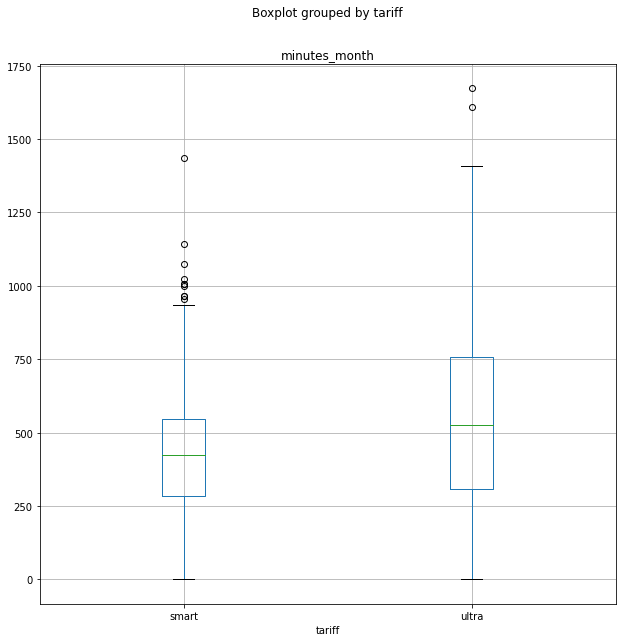

In [348]:
plot = final_data.boxplot('minutes_month', by='tariff', figsize=(10,10))

<AxesSubplot:title={'center':'Минуты в месяц'}, xlabel='Минуты в месяц', ylabel='Frequency'>

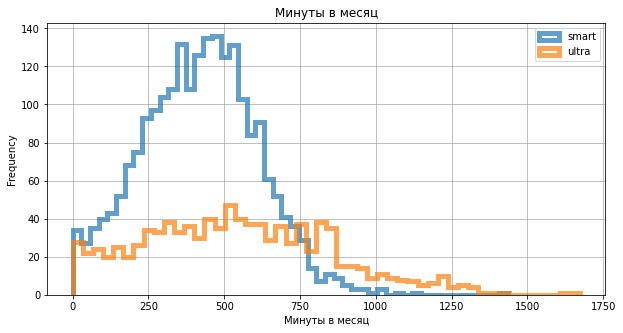

In [349]:
hist_two_data(smart, ultra, 'minutes_month', title = 'Минуты в месяц')

Данные скошены вправо, медиана меньше среднего. В наборе данных есть выбросы - закономерно в Смарт выбросов больше, так как ряду абонентов не хватает включенных в тариф 500 минут. Больше 750 минут в месяц абоненты Смарт говорят даже чаще абонентов Ультра.

**Сообщения по тарифам**

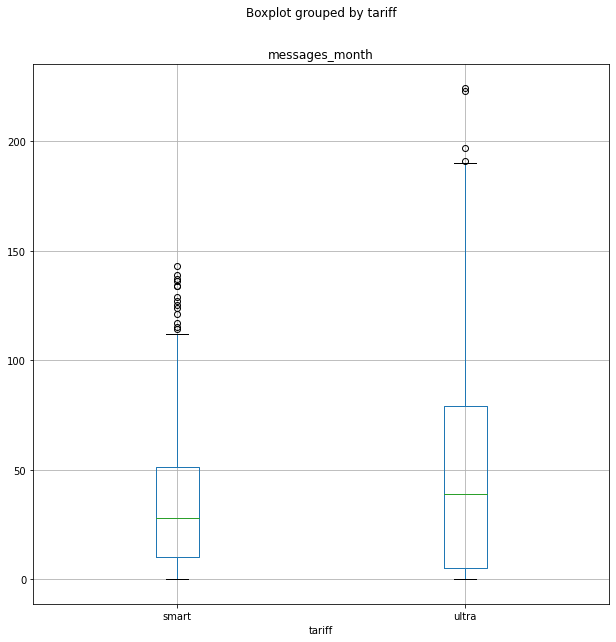

In [350]:
plot = final_data.boxplot('messages_month', by='tariff', figsize=(10,10))

<AxesSubplot:title={'center':'СМС-сообщения в месяц'}, xlabel='СМС-сообщения в месяц', ylabel='Frequency'>

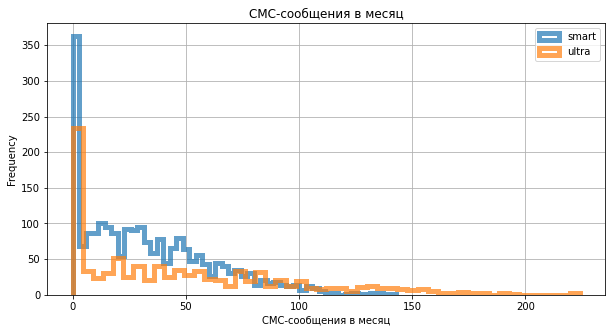

In [351]:
hist_two_data(smart, ultra, 'messages_month', title = 'СМС-сообщения в месяц')

СМС-сообщения в большинстве своем абоненты двух тарифов пишут нечасто, высокий пик со значением примерно 10 смс в месяц и далее резкий спад, но в то же время данные очень сильно скошены вправо, особенно в тарифе Ультра, что говорит, о  большем количестве нечастых дополнительных значений. Несмотря на длинный "хвост" в гистограммах тарифов справа (много редких значений, выбросы), абоненты Ультра умещаются в тарифный план. Абоненты Смарт пишут СМС больше и ряд из них выходит за рамки тарифного плана.

**Интернет-трафик в месяц**

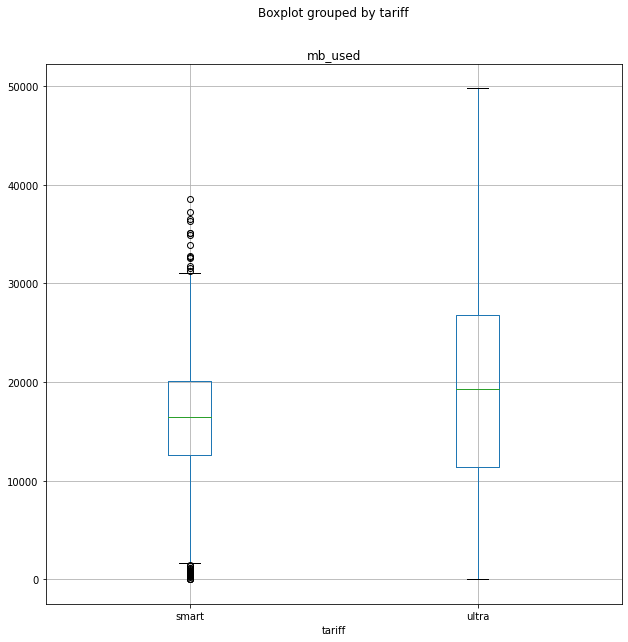

In [352]:
plot = final_data.boxplot('mb_used', by='tariff', figsize=(10,10))

<AxesSubplot:title={'center':'Интернет_трафик в месяц'}, xlabel='Интернет_трафик в месяц', ylabel='Frequency'>

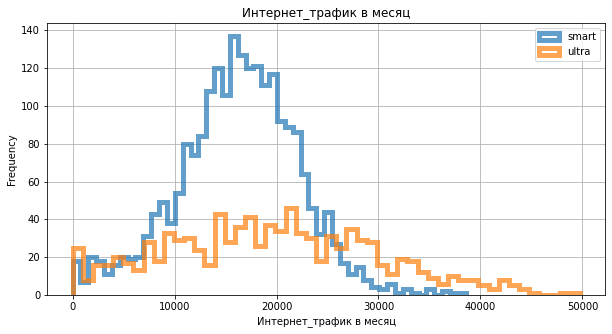

In [353]:
hist_two_data(smart, ultra, 'mb_used', title = 'Интернет_трафик в месяц')

Графики по Интерент-трафику в месяц наиболее приближены к нормальному распределению. Связано это скорее всего с возрастом абонентов. Анализируя их портрет мы видели, что в топе много абонентов старшего возраста, скорее всего именно они "дали нам" низкие значения интернет-трафика. Все остальные "распределили" центр и максимальные значения. На гистограмме видно, что абоненты двух тарифов выходят за тарифный план (для абонентов Ультра - 30720 мб, для Смарт - 15360 мб.), но абоненты Смарт делают это чаще.

**Доход по тарифам**

<AxesSubplot:title={'center':'Доход в месяц'}, xlabel='Доход в месяц', ylabel='Frequency'>

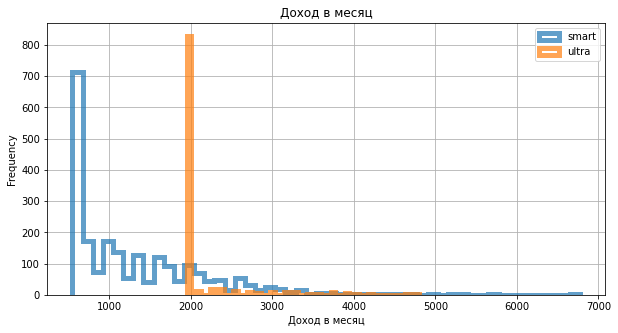

In [354]:
hist_two_data(smart, ultra, 'month_income', title = 'Доход в месяц')

Мы видим, что хоть пик доходности в Ультра выше да и само значение, принадлежащее пику (2000 руб) больше, чем у Смарт, после взлета идет моментальное падение и "хвост" из редких значений справа небольшой - переплаты случаются достаточно редко. Доходность Смарт после пика дает более плавную скошенность вправо и более длинный список дополнительных значений справа, которые увеличивают среднее. А за счет многочисленности абонентов в тарифе Смарт, перед проверкой гипотез, мы уже можем предположить, что тариф Смарт более доходен, чем Ультра.

In [355]:
#для удаления выбросов по столбцу из датафрейма
def clean_data(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3-q1
    
    clean_column = (data[column] >= (q1-1.5*iqr)) & (data[column] <= (q3+1.5*iqr ))
    
    return data.loc[clean_column]

In [356]:
# удаляем выбросы
clean_smart = clean_data(smart, 'month_income')
len(clean_smart)

2194

In [357]:
# удаляем выбросы
clean_ultra = clean_data(ultra, 'month_income')
len(clean_ultra)

829

## Гипотезы и их проверка

Далее проверим гипотезы о равенстве средних двух генеральных совокупностей, проведя т-тесты.

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

**Н0 (нулевая гипотеза)**
Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны

**Н1 (альтернативная гипотеза)**
Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны

Уровень значимости alpha примем за 0.05, общепринятое значение, которое позволит уменьшить риск (в отличие от 0,01) ошибки (например, риск не отвергнуть ложную нулевую гипотезу)

In [358]:
#выборки
smart_income = clean_smart['month_income']
ultra_income = clean_ultra['month_income']

In [359]:
# тест, equal_var=False - так как выборки разного размера
alpha = 0.05
result = st.ttest_ind(smart_income, ultra_income, equal_var=False)
print('р-значение', result.pvalue)

р-значение 5.22963757e-315


In [360]:
#интерпретация результата
if result.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

Принимаем альтернативную гипотезу


По результатам т-теста нулевая гипотеза о равенстве средних не подтвердилась, была принята альтернативная гипотеза, о том что средние выручки пользователей Смарт и Ультра не равны. 
Разница неслучайна, есть значимые отличия между двумя выборками.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

**Н0 (нулевая гипотеза)**
Cредняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов

**Н1 (альтернативная гипотеза)**
Средняя выручка пользователей  из Москвы  не равна средней выручке пользователей из других регионов

In [361]:
#подготовим выборку по Москве
moscow_data = final_data.loc[final_data['city'] == 'москва']
clean_moscow_data = clean_data(moscow_data, 'month_income')
test_moscow = clean_moscow_data['month_income']

In [362]:
#оценим размер выборки
len(clean_moscow_data), len(clean_moscow_data)/len(moscow_data)

(605, 0.9918032786885246)

In [363]:
#подготовим выборку по регионам
region_data = final_data.loc[final_data['city'] != 'москва']
clean_region_data = clean_data(region_data, 'month_income')
test_region = clean_region_data['month_income']

In [364]:
#оценим размер выборки
len(clean_region_data), len(clean_region_data)/len(region_data)

(2541, 0.9728177641653905)

In [365]:
#проведем тест
alpha = 0.05
result = st.ttest_ind(test_moscow,test_region)
print('р-значение', result.pvalue)

р-значение 0.2324185702354845


In [366]:
#интерпретация результата
if result.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

Опровергнуть нулевую гипотезу нельзя


По результатам т-теста отвергнуть нулевую гипотезу о равенстве средних не получилось. Полученное р-значение говорит о том, что с вероятностью в 23% мы можем получить такое или большее различие случайно, и хотя средние в группировке по тарифам и не равны, значимых различий между Москвой и регионами выявить не получилось.

## Выводы

В рамках проекта мы исследовали выборку из 500 абонентов "Мегалайн" (выборка, вероятно, стратифицированная, судя по разному количеству абонентов в каждом из тарифов, и соответственно более репрезентативная).

Были обработаны таблицы с данными об абонентах, звонках, интернет-сессиях и смс-сообщениях за 2018 год.

Цель проекта - определить более доходный тариф.

В процессе подготовки данных удаления информации не было, звонки длительностью 0, оставили как 0 (основания - пояснительная записка к проекту, соразмерное распределение по тарифам, не стали увеличивать показатели дохода, не имея на то веских оснований).

**Проверка гипотезы о равенстве средних Ультра и Смарт, отвергла это равенство и подтвердила различия между выборками по тарифам. На основании исследовательского анализа и проверки гипотезы более доходным признаем тариф Смарт:**
- **Абоненты Смарт переплачивают в среднем вдвое. Примерно половина среднего ежемесячного платежа - абонентская плата. Остальное - услуги сверх тарифа.**
- **Абоненты с большoй вероятностью доплачивают за интернет, с чуть меньшей за звонки и почти не переплачивают за смс-сообщения.**
- **За счет массовости тарифа Смарт, все вышеперечисленное дает бОльший доход.**
- **Пользователи Ультра хоть и платят бОльшую абонентскую плату, их меньше и переплачивают они меньшие суммы сверх тарифа и реже. Самый частый вид переплат - за Интернет.**

При корректировке рекламного бюджета нужно учесть, что гипотеза о равенстве средних доходов из Москвы и из регионов не была отвергнута, то есть значимых различий между доходностью Москвы и регионов выявить не удалось.

*Наблюдения:*
- *при дальшейшей выгрузке данных и подготовке сопроводительной записки к проектам нужно все же разобраться со звонками длительностью 0 и прописать их особенность в документации*
- *выборка по закончившим договор была небольшой, но даже в ней "лидирует" Ультра, куда потом ушли отказники?, на какой тариф? или вообще к другому оператору?*
- *смс-сообщения - "вымирающий жанр", может быть и не нужно их так много предлагать в пакете услуг?*
